<H1>Predicting 2021 Chesapeake Bay Blue Crab Abundance using Autoregressive Modeling and Time-series Decomposition   </H1>
<H3> 08/26/2020 </H3>

<h3>Time-series analyses look at how variables evolve over time. Autoregression models can be build using a single time-series, these models are used to predict future values for a given variable using information at time points that have already occurred. This brief report uses historical time-series data from the ChesapeakeProgress website (<a href="https://www.chesapeakeprogress.com/abundant-life/blue-crab-abundance">Link</a>) to forecast spawning-age female blue crab abundance for 2021. Autoregressive Integrated Moving Average (ARIMA) and seasonal ARIMA (SARIMA) modeling techniques are utilized. The dataset demonstrates overall stationarity, favoring an autoregressive component over a moving average component when using all historical data for model construction. A second model built from a seasonal pattern between 2008 and 2020 is also assessed. Predictions from both models are compared to reach a general conclusion.  </h3>

<h3>Load everything</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
rcParams['figure.figsize'] = 12,8
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

<h3>Assign data to a pandas dataframe with annual time-series indexing</h3>

In [2]:
df = pd.read_csv('BC.csv',index_col=0,parse_dates=True)
df.index.freq = 'AS'

<H3>The dataframe contains spawning-age female blue crab abundance data (in millions) from 1990 to 2020</H3>

In [3]:
df.head(),df.tail()

(            actual
 year              
 1990-01-01   117.0
 1991-01-01   227.0
 1992-01-01   167.0
 1993-01-01   177.0
 1994-01-01   102.0,
             actual
 year              
 2016-01-01   194.0
 2017-01-01   254.0
 2018-01-01   147.0
 2019-01-01   191.0
 2020-01-01   141.0)

<h3>Dickey-Fuller test for stationarity</h3>

In [4]:
adfuller(df,autolag='AIC')[1] #p < 0.05, so it is safe to assume there is no overall trend

0.031832439618638374

<h3>The time-series exhibits a positive autocorrelation about its mean</h3>

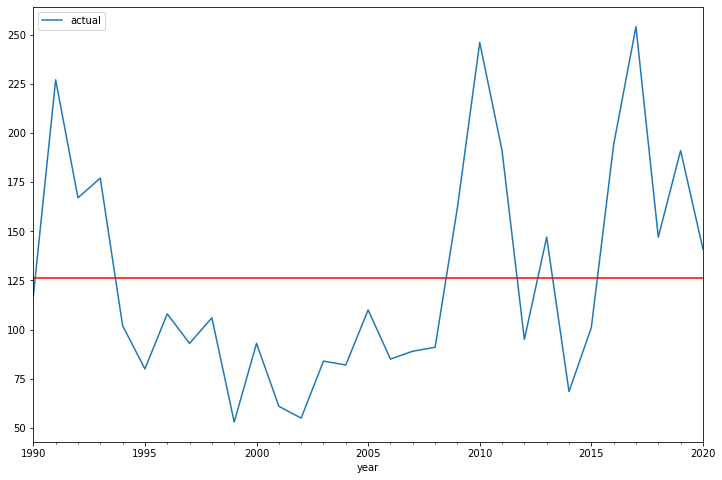

In [5]:
df.plot();
plt.axhline(float(df.mean()),color = 'red');

<h3>An autocorrelation plot shows that each time point is correlated with the time point one year prior</h3>
Only time lags of 0 and 1 have autocorrelations large enough to be outside of the 95% confidence interval

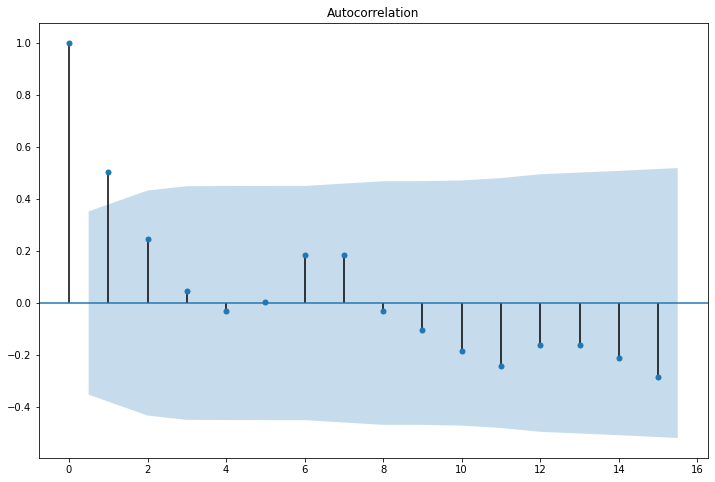

In [6]:
plot_acf(df);

<h3>The autocorrelation coefficient for one year of lag can be estimated by calculating the correlation coefficient between the time-series and itself shifted by one year</h3> 

In [7]:
df['actual'].corr(df['actual'].shift(1))

0.5041061330308001

<h3>Female blue crabs fully develope within the span of a year, which explains the 1 year lag.</h3>

<h3>Before the autoregression model is constructed, the last time point is split from the training set and assigned to a test set</h3>
This will allow us to evalute the model's accuracy at forecasting values one year in the future

In [8]:
train = df[:-1]
test = df[-1:]

<h3>The model is constructed using the ARIMA function</h3>
The autoregression parameter (p) in the "order" argument is set to 1 

In [9]:
model_test = ARIMA(train,order=(1, 0, 0)).fit()

<h3>The model generates a prediction to test against the actual 2020 value</h3>

In [10]:
pred_test = model_test.predict(start=len(train),end=len(train)+len(test)-1,typ='levels').rename('pred')

In [11]:
pred_test[0]

159.3811921859634

In [12]:
test['actual'][0]

141.0

<h3>There is a difference of about 18 million crabs between the predicted and actual values</h3>

In [13]:
 pred_test[0] - test['actual'][0]

18.381192185963414

<h3>The root mean squared error yields the same result when evaluating a single prediction</h3>

In [14]:
rmse(test['actual'],pred_test)

18.381192185963414

<h3>Let's plot our prediction against our dataset</h3>

In [15]:
idx = pd.date_range('2019-01-01',periods=2,freq='AS')
ser = pd.Series([191,pred_test[0]],index=idx).rename('pred')
ser

2019-01-01    191.000000
2020-01-01    159.381192
Freq: AS-JAN, Name: pred, dtype: float64

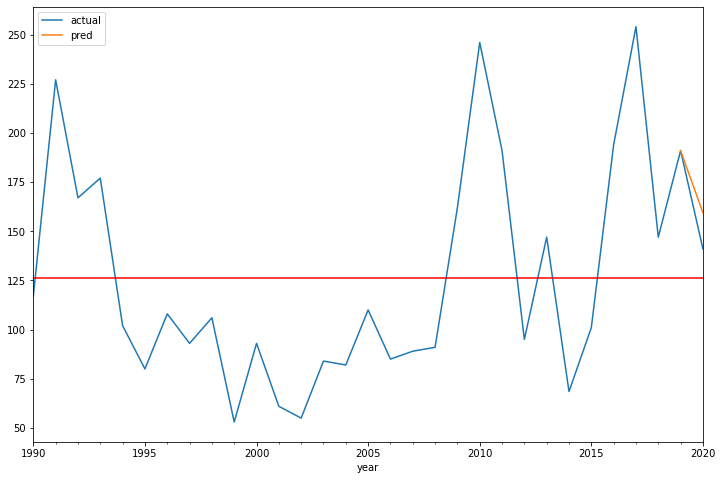

In [16]:
df.plot();
ser.plot(legend=True);
plt.axhline(float(df.mean()),color = 'red');

<h3>2021 Forecast!!!</h3>
This time we want to retrain our model using the entire dataset

In [17]:
fcast_2021 = ARIMA(df,order=(1, 0, 0)).fit()

In [18]:
fcast = fcast_2021.predict(start=len(df),end=len(df),typ='levels').rename('fcast')

<h3>We forecast that there will be around 133 million spawning-age female blue crabs in the Chesapeake Bay when ChesapeakeProgress makes its measurement in 2021</h3> 

In [19]:
fcast[0]

133.6073605502345

<h3>Let's plot our forecast</h3>

In [20]:
idx_2 = pd.date_range('2020-01-01',periods=2,freq='AS')
ser_2 = pd.Series([141,fcast[0]],index=idx_2).rename('fcast')
ser_2

2020-01-01    141.000000
2021-01-01    133.607361
Freq: AS-JAN, Name: fcast, dtype: float64

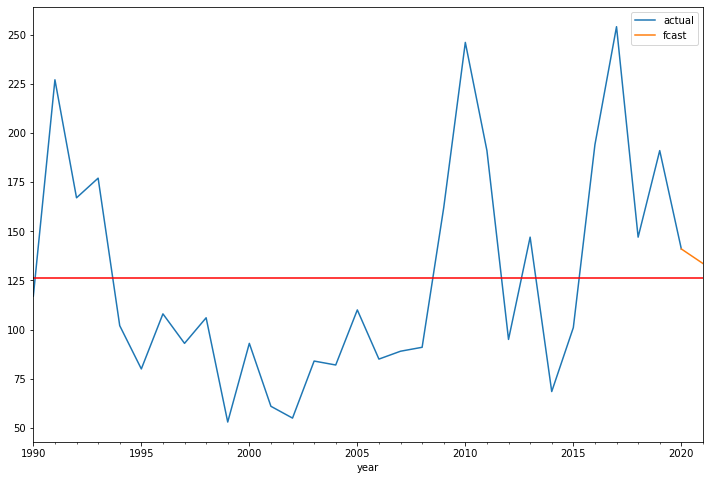

In [21]:
df.plot();
ser_2.plot(legend=True);
plt.axhline(float(df.mean()),color = 'red');

<h2>Effect of 2008 crabbing guidelines</h2>

<h3>A great explanation for the behavior of our time-series data can be found at the Chesapeake Bay Foundation website (<a href="https://www.cbf.org/about-the-bay/more-than-just-the-bay/chesapeake-wildlife/blue-crabs/">Link</a>). Overfishing in the 90s led to a reduction in the overall crab population until 2008 crabbing guidelines placed greater restrictions on crabbers.  </h3>

<h3>Let's remove all years before 2008 from our dataset</h3>

In [22]:
df_2 = df.loc['2008-01-01':]

<h3>There appears to be a 6 year cycle in the data</h3>

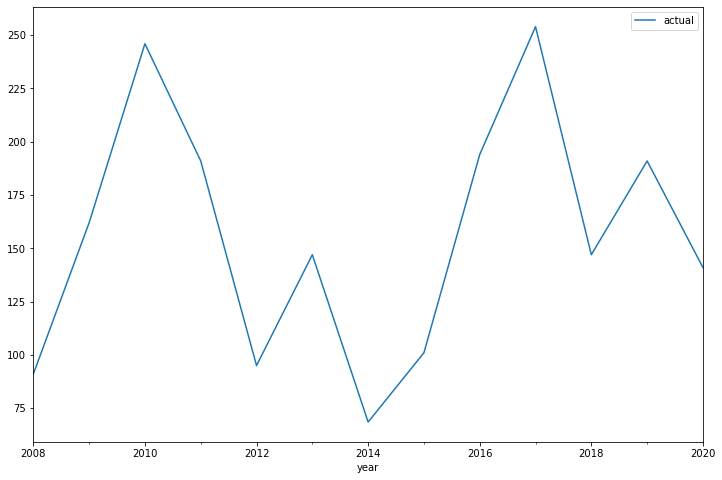

In [23]:
df_2.plot();

<h3>There is no autocorrelation when looking at the past 12 years</h3>

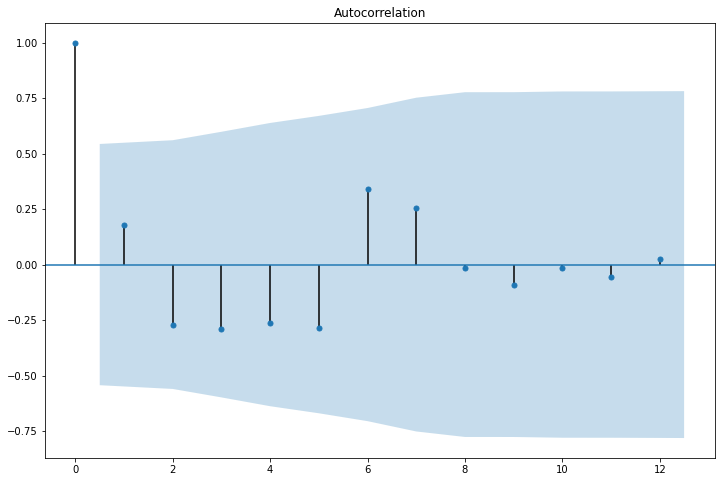

In [24]:
plot_acf(df_2);

<h3>Seasonal decomposition will be used to extract a 6 year seasonal component</h3>

In [25]:
seasons = seasonal_decompose(df_2,period=6)

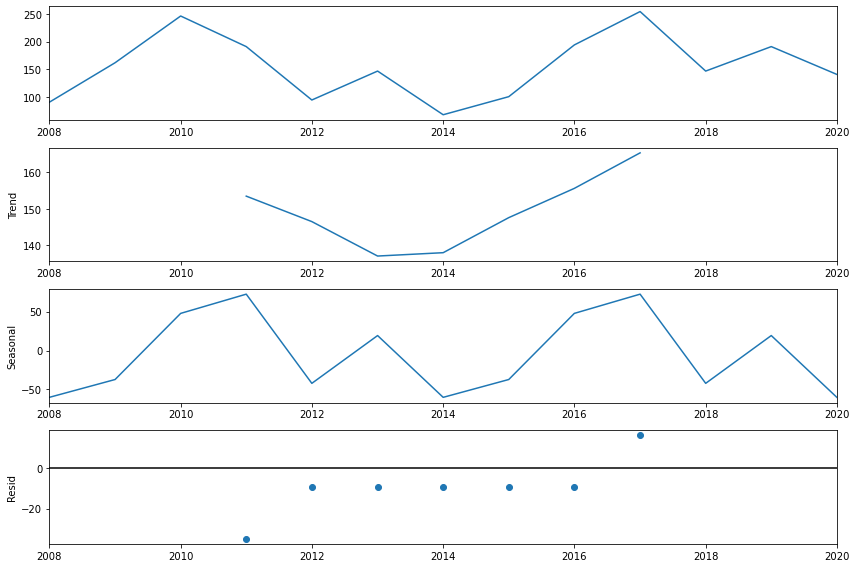

In [26]:
seasons.plot();

<h3>The auto_arima function determines that there is no autoregressive component in the observed data</h3>

In [27]:
auto_arima(seasons.observed)

C:\Users\ffste\anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(order=(0, 0, 0))

<h3>But...our seasonal function has a 2 year autoregressive component as well as a 2 year moving average component</h3>

In [28]:
auto_arima(seasons.seasonal)

C:\Users\ffste\anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\ffste\anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\ffste\anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\ffste\anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\ffste\anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum

ARIMA(order=(2, 0, 2))

<h3>The second model is constructed using the SARIMAX function</h3>
The autoregression parameter (p) is set to 2, while the moving average component (q) is set to 2  

In [29]:
sar = SARIMAX(df_2['actual'],order=(0,0,0),seasonal_order=(2,0,2,6)).fit()

<h3>2021 Forecast!!! (take 2!!!)</h3>

In [30]:
pred_2 = sar.predict(len(df_2),len(df_2),typ='levels').rename('SARIMA')

In [31]:
pred_2

2021-01-01    134.535054
Freq: AS-JAN, Name: SARIMA, dtype: float64

<h3>Let's plot our forecast</h3>

In [32]:
idx_3 = pd.date_range('2020-01-01',periods=2,freq='AS')
ser_3 = pd.Series([141,pred_2[0]],index=idx_3).rename('pred_2')
ser_3

2020-01-01    141.000000
2021-01-01    134.535054
Freq: AS-JAN, Name: pred_2, dtype: float64

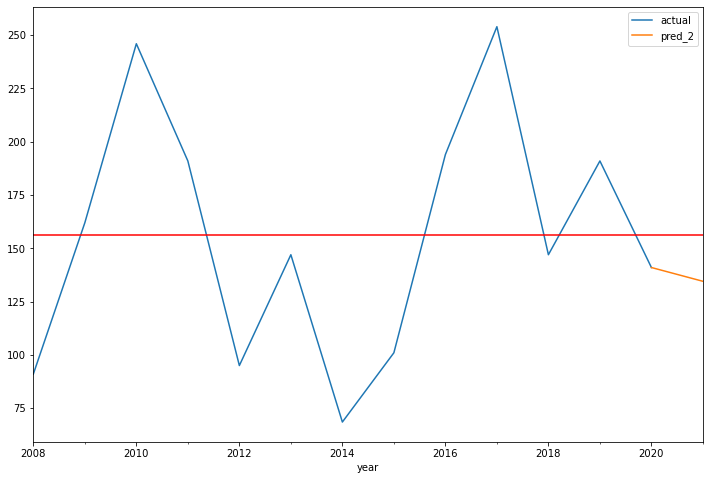

In [33]:
df_2.plot();
ser_3.plot(legend=True);
plt.axhline(float(df_2.mean()),color = 'red');

<h3> In conclusion, our prediction using a SARMA model from 2008 to 2020 doesn't deviate from our prediction using an AR model from 1990 to 2020. From this I predict that the ChesapeakeProgress 2021 report on the spawning-age female blue crab population will not be below 133 million, although it is certainly feasible that the population exhibits exponential growth by that time. Future analyses should include variables correlated with the Chesapeake Bay blue crab population, such as salinity levels and bay grass density. </h3> 

<img src="crab.jpg"/>